In [2]:
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet50
from tqdm import tqdm
import l5kit
from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points,rotation33_as_yaw,yaw_as_rotation33
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path
import os
from l5kit.data.filter import filter_agents_by_frames, filter_agents_by_track_id


In [3]:
torch.cuda.is_available()

False

In [2]:
print(l5kit.__file__)

/home/sadeghkhorasani/lyft_proj/l5kit/examples/agent_motion_prediction/l5kit/__init__.py


## Prepare Data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params...).

In [153]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/home/mkhorasa/lyft_data/"
dm = LocalDataManager(None)
# get config
cfg = load_config_data("./agent_motion_config-history.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 10, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map.png', 'semantic_map_key': 'semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5}, 'train_data_loader': {'key': 'train_full.zarr', 'batch_size': 100, 'shuffle': True, 'num_workers': 20}, 'val_data_loader': {'key': 'sample.zarr', 'batch_size': 50, 'shuffle': False, 'num_workers': 16}, 'train_params': {'checkpoint_every_n_steps': 10000, 'max_num_steps': 70000, 'eval_every_n_steps': 10000}}


## Model

Our baseline is a simple `resnet50` pretrained on `imagenet`. We must replace the input and the final layer to address our requirements.

In [5]:
def build_model(cfg: Dict) -> torch.nn.Module:
    # load pre-trained Conv2D model
    model = resnet50(pretrained=True)

    # change input channels number to match the rasterizer's output
    num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
    num_in_channels = 3 + num_history_channels
    model.conv1 = nn.Conv2d(
        num_in_channels,
        model.conv1.out_channels,
        kernel_size=model.conv1.kernel_size,
        stride=model.conv1.stride,
        padding=model.conv1.padding,
        bias=False,
    )
    # change output size to (X, Y) * number of future states
    num_targets = 2 * cfg["model_params"]["future_num_frames"]
    model.fc = nn.Linear(in_features=2048, out_features=num_targets)

    return model

In [6]:
def forward(data, model, device, criterion):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    targets = data["target_positions"].to(device)
    # Forward pass
    outputs = model(inputs).reshape(targets.shape)
    loss = criterion(outputs, targets)
    # not all the output steps are valid, but we can filter them out from the loss using availabilities
    loss = loss * target_availabilities
    loss = loss.mean()
    return loss, outputs

## Load the Train Data

Our data pipeline map a raw `.zarr` folder into a multi-processing instance ready for training by:
- loading the `zarr` into a `ChunkedDataset` object. This object has a reference to the different arrays into the zarr (e.g. agents and traffic lights);
- wrapping the `ChunkedDataset` into an `AgentDataset`, which inherits from torch `Dataset` class;
- passing the `AgentDataset` into a torch `DataLoader`

In [3]:
# ===== INIT DATASET
train_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])
print(train_dataset)
print(len(train_dataset))

+------------+------------+------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   134622   |  33437057  | 2655096629 |      928.68     |        248.38        |        79.41         |        24.83         |        10.00        |
+------------+------------+------------+-----------------+----------------------+----------------------+----------------------+---------------------+
191177863


In [4]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")


In [ ]:
# ==== INIT MODEL
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = build_model(cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction="none")

In [5]:
data=train_dataset[420]
print(data["history_positions"])
print(data["history_yaws"])
plt.plot(data["history_positions"][:,0], data["history_positions"][:,1],'ro')
print(data["history_availabilities"])

[[ 0.0000000e+00  0.0000000e+00]
 [-7.5109744e-01 -8.6431578e-03]
 [-1.4983776e+00 -5.1181852e-03]
 [-2.2822468e+00 -3.5146568e-03]
 [-3.1252344e+00  4.7146291e-02]
 [-3.9739213e+00  6.9238432e-02]
 [-4.7917900e+00  7.1784787e-02]
 [-5.6438389e+00  5.2648444e-02]
 [-6.4936571e+00  6.0760226e-02]
 [-7.3675528e+00  5.0670277e-02]
 [-8.2735796e+00  6.6393979e-02]
 [-9.1861486e+00  8.2799517e-02]
 [-1.0118058e+01  1.1811754e-01]
 [-1.1104966e+01  1.3809134e-01]
 [-1.2113733e+01  1.5538453e-01]
 [-1.3139129e+01  1.7838085e-01]]
[[0.        ]
 [0.00126123]
 [0.00318789]
 [0.00701237]
 [0.00829554]
 [0.00805593]
 [0.00688457]
 [0.0072    ]
 [0.00670862]
 [0.0077095 ]
 [0.00876594]
 [0.01070952]
 [0.01169109]
 [0.01244116]
 [0.01355338]
 [0.01375151]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [99]:
def world_to_image_pixels(
    image_shape,
    pixel_size_m: np.ndarray,
    ego_translation_m: np.ndarray,
    ego_yaw_rad
) :

    world_to_ego_in_2d = np.eye(3, dtype=np.float32)
    world_to_ego_in_2d[0:2, 2] = -ego_translation_m[0:2]
    # Scale the meters to pixels.
    world_to_image_scale = np.eye(3)
    world_to_image_scale[0, 0] = 1.0 / pixel_size_m[0]
    world_to_image_scale[1, 1] = 1.0 / pixel_size_m[1]

    # Move so that it is aligned to the defined image center.
    ego_center_in_image_ratio = np.array(cfg["raster_params"]["ego_center"])
    ego_center_in_pixels = ego_center_in_image_ratio * image_shape
    image_to_ego_center = np.eye(3)
    image_to_ego_center[0:2, 2] = ego_center_in_pixels

    # Construct the whole transform and return it.
    return image_to_ego_center @ world_to_image_scale @ world_to_ego_in_2d

to_pixel=world_to_image_pixels(cfg["raster_params"]["raster_size"],cfg["raster_params"]["pixel_size"], data["centroid"][:2], data["yaw"],
                     )

In [104]:
rotated_positions=data["history_positions"]
unrotated_positions = transform_points(
    np.concatenate([data["history_positions"]]),  yaw_as_rotation33(data["yaw"]))
plt.plot(rotated_positions[:,0], rotated_positions[:,1],'ro')




In [112]:
f_rotated_positions=data["target_positions"]
f_unrotated_positions = transform_points(
    np.concatenate([data["target_positions"]]),  yaw_as_rotation33(data["yaw"]))


In [117]:

im = data["image"].transpose(1, 2, 0)
im = train_dataset.rasterizer.to_rgb(im)

target_positions_pixels = transform_points(rotated_positions + data["centroid"][:2],to_pixel)
draw_trajectory(im, target_positions_pixels, data["history_yaws"], PREDICTED_POINTS_COLOR)

# target_positions_pixels = transform_points(f_rotated_positions + data["centroid"][:2],to_pixel)
# draw_trajectory(im, target_positions_pixels, data["target_yaws"], PREDICTED_POINTS_COLOR)


# target_positions_pixels = transform_points(rotated_positions + data["centroid"][:2],to_pixel)
# draw_trajectory(im, target_positions_pixels, data["history_yaws"], PREDICTED_POINTS_COLOR)


# target_positions_pixels = transform_points(unrotated_positions + data["centroid"][:2], data["world_to_image"])
# draw_trajectory(im, target_positions_pixels, data["history_yaws"], TARGET_POINTS_COLOR)



# target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
# draw_trajectory(im, target_positions_pixels, data["target_yaws"], TARGET_POINTS_COLOR)
plt.plot(target_positions_pixels[:,0], target_positions_pixels[:,1],'ro')

# print(target_positions_pixels)
plt.imshow(im[::-1])
plt.show()

In [190]:
data['track_id']

237

In [ ]:
# filter_agents_by_track_id(train_dataset.dataset.agents,237)
train_dataset.dataset.agents[np.nonzero(train_dataset.dataset.agents["track_id"] == 237)]

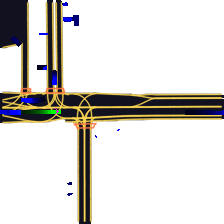

In [105]:
from IPython.display import display, clear_output
import PIL
 
cfg["raster_params"]["map_type"] = "py_semantic"
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, train_zarr, rast)
scene_idx = 6
indexes = dataset.get_scene_indices(scene_idx)
images = []
frames=[]
for idx in indexes:
    
    data = dataset[idx]
    im = data["image"].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)
    target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
    center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    draw_trajectory(im, target_positions_pixels, data["target_yaws"], TARGET_POINTS_COLOR)
    clear_output(wait=True)
    image=PIL.Image.fromarray(im[::-1])
    frames.append(image)
    display(image)

In [108]:
dataset.dataset.frames

<zarr.core.Array '/frames' (33437057,) [('timestamp', '<i8'), ('agent_index_interval', '<i8', (2,)), ('traffic_light_faces_index_interval', '<i8', (2,)), ('ego_translation', '<f8', (3,)), ('ego_rotation', '<f8', (3, 3))] read-only>

In [106]:
import gifmaker
# write GIF animation
print(type(frames[0]))
# for frames in frameses:
#     frames[0].save("/toSee/out"+scene_idx+".gif", save_all=True, append_images=frames[1:],duration=1, loop=1)
frames[0].save("./2.gif", save_all=True, append_images=frames[1:],duration=1, loop=1)




<class 'PIL.Image.Image'>


In [103]:
pip install moviepy

    100% |████████████████████████████████| 389kB 3.3MB/s ta 0:00:01
  Running setup.py bdist_wheel for moviepy ... done
  Stored in directory: /home/mkhorasa/.cache/pip/wheels/e0/fe/1c/f4e6dca9e828d4b979c04e461d7fcc5b8e7bd35f947e665b65
  Running setup.py bdist_wheel for proglog ... done
  Stored in directory: /home/mkhorasa/.cache/pip/wheels/65/56/60/1d0306a8d90b188af393c1812ddb502a8821b70917f82dcc00
  Running setup.py bdist_wheel for imageio-ffmpeg ... done
  Stored in directory: /home/mkhorasa/.cache/pip/wheels/a4/97/d4/c700927e4f2da1db33918b51d6a9eeaabc430f7ed8cb3fb362
Successfully built moviepy proglog imageio-ffmpeg
You are using pip version 18.1, however version 20.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [8]:
# for load from saved files
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = build_model(cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction="none")
model.load_state_dict(torch.load("mysavedmodel"))


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/sadeghkhorasani/.cache/torch/checkpoints/resnet50-19c8e357.pth


<All keys matched successfully>

***FOR E and Var***

In [ ]:
# ==== TRAIN LOOP
tr_it = iter(train_dataloader)
progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))
losses_train = []
for _ in progress_bar:
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)
    model.train()
    torch.set_grad_enabled(True)
    loss, _ = forward(data, model, device, criterion)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_train.append(loss.item())
    progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")

# Training

note: if you're on MacOS and using `py_satellite` rasterizer, you may need to disable opencv multiprocessing by adding:
`cv2.setNumThreads(0)` before the following cell. This seems to only affect running in python notebook and it's caused by the `cv2.warpaffine` function

In [ ]:
# ==== TRAIN LOOP
tr_it = iter(train_dataloader)
progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))
losses_train = []
for _ in progress_bar:
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)
    model.train()
    torch.set_grad_enabled(True)
    loss, _ = forward(data, model, device, criterion)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_train.append(loss.item())
    progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")

# Evaluation

Evaluation follows a slightly different protocol than training. When working with time series, we must be absolutely sure to avoid leaking the future in the data.

If we followed the same protocol of training, one could just read ahead in the `.zarr` and forge a perfect solution at run-time, even for a private test set.

As such, **the private test set for the competition has been "chopped" using the `chop_dataset` function**.

## DISCLAIMER
**We're updating the dataset to support traffic lights. The code below has been designed to work with TLs, and it does not suppport the old interface. We expect the dataset to be online in the next few days** ( disclaimer added on 08/18/20)

In [9]:
# ===== GENERATE AND LOAD CHOPPED DATASET
num_frames_to_chop = 100
eval_cfg = cfg["val_data_loader"]
eval_base_path = create_chopped_dataset(dm.require(eval_cfg["key"]), cfg["raster_params"]["filter_agents_threshold"], 
                              num_frames_to_chop, cfg["model_params"]["future_num_frames"], MIN_FUTURE_STEPS)

traffic_light_faces not found in /data/sadeghkhorasani/lyft/train_0.zarr! Traffic lights will be disabled


copying:   0%|          | 0/16253 [00:00<?, ?it/s]

traffic_light_faces not found in /data/sadeghkhorasani/lyft/train_0.zarr! Traffic lights will be disabled
zarr dataset path doesn't exist. Open will fail for this dataset!


ValueError: no field of name traffic_light_faces_index_interval

The result is that **each scene has been reduced to only 100 frames**, and **only valid agents in the 100th frame will be used to compute the metrics**. Because following frames in the scene have been chopped off, we can't just look ahead to get the future of those agents.

In this example, we simulate this pipeline by running `chop_dataset` on the validation set. The function stores:
- a new chopped `.zarr` dataset, in which each scene has only the first 100 frames;
- a numpy mask array where only valid agents in the 100th frame are True;
- a ground-truth file with the future coordinates of those agents;

In [ ]:
eval_zarr_path = str(Path(eval_base_path) / Path(dm.require(eval_cfg["key"])).name)
eval_mask_path = str(Path(eval_base_path) / "mask.npz")
eval_gt_path = str(Path(eval_base_path) / "gt.csv")

eval_zarr = ChunkedDataset(eval_zarr_path).open()
eval_mask = np.load(eval_mask_path)["arr_0"]
# ===== INIT DATASET AND LOAD MASK
eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer, agents_mask=eval_mask)
eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
                             num_workers=eval_cfg["num_workers"])
print(eval_dataset)

Please note how `Num Frames==(Num Scenes)*num_frames_to_chop`. 

The remaining frames in the scene have been sucessfully chopped off from the data

In [ ]:
# ==== EVAL LOOP
model.eval()
torch.set_grad_enabled(False)

# store information for evaluation
future_coords_offsets_pd = []
timestamps = []

agent_ids = []
progress_bar = tqdm(eval_dataloader)
for data in progress_bar:
    _, ouputs = forward(data, model, device, criterion)
    future_coords_offsets_pd.append(ouputs.cpu().numpy().copy())
    timestamps.append(data["timestamp"].numpy().copy())
    agent_ids.append(data["track_id"].numpy().copy())
    

### Save results
After the model has predicted trajectories for our evaluation set, we can save them in a `csv` file.

During the competition, only the `.zarr` and the mask will be provided for the private test set evaluation.
Your solution is expected to generate a csv file which will be compared to the ground truth one on a separate server

In [ ]:
pred_path = f"{gettempdir()}/pred.csv"

write_pred_csv(pred_path,
               timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(future_coords_offsets_pd),
              )

### Perform Evaluation
Pleae note that our metric supports multi-modal predictions (i.e. multiple predictions for a single GT trajectory). In that case, you will need to provide a confidence for each prediction (confidences must all be between 0 and 1 and sum to 1).

In this simple example we don't generate multiple trajectories, so we won't pass any confidences vector. Internally, the metric computation will assume a single trajectory with confidence equal to 1

In [ ]:
metrics = compute_metrics_csv(eval_gt_path, pred_path, [neg_multi_log_likelihood, time_displace])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)


### Visualise Results
We can also visualise some results from the ego (AV) point of view for those frames of interest (the 100th of each scene).

However, as we chopped off the future from the dataset **we must use the GT csv if we want to plot the future trajectories of the agents**


In [ ]:
model.eval()
torch.set_grad_enabled(False)

# build a dict to retrieve future trajectories from GT
gt_rows = {}
for row in read_gt_csv(eval_gt_path):
    gt_rows[row["track_id"] + row["timestamp"]] = row["coord"]

eval_ego_dataset = EgoDataset(cfg, eval_dataset.dataset, rasterizer)

for frame_number in range(99, len(eval_zarr.frames), 100):  # start from last frame of scene_0 and increase by 100
    agent_indices = eval_dataset.get_frame_indices(frame_number) 
    if not len(agent_indices):
        continue

    # get AV point-of-view frame
    data_ego = eval_ego_dataset[frame_number]
    im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
    center = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    
    predicted_positions = []
    target_positions = []

    for v_index in agent_indices:
        data_agent = eval_dataset[v_index]

        out_net = model(torch.from_numpy(data_agent["image"]).unsqueeze(0).to(device))
        out_pos = out_net[0].reshape(-1, 2).detach().cpu().numpy()
        # store absolute world coordinates
        predicted_positions.append(out_pos + data_agent["centroid"][:2])
        # retrieve target positions from the GT and store as absolute coordinates
        track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
        target_positions.append(gt_rows[str(track_id) + str(timestamp)] + data_agent["centroid"][:2])


    # convert coordinates to AV point-of-view so we can draw them
    predicted_positions = transform_points(np.concatenate(predicted_positions), data_ego["world_to_image"])
    target_positions = transform_points(np.concatenate(target_positions), data_ego["world_to_image"])

    yaws = np.zeros((len(predicted_positions), 1))
    draw_trajectory(im_ego, predicted_positions, yaws, PREDICTED_POINTS_COLOR)
    draw_trajectory(im_ego, target_positions, yaws, TARGET_POINTS_COLOR)

    plt.imshow(im_ego[::-1])
    plt.show()